In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

/home/viswanath/anaconda3/envs/ntensorflowenv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
print(os.getcwd())

/home/viswanath/Desktop/Myfiles/AML/Capstone/Code


In [3]:
path = '/home/viswanath/Desktop/Myfiles/AML/Capstone/Data/'
#path = '/Users/vishy/Files/Kaggle/Whale/Data/'
train_images = glob(path+'train/*jpg') # imports the train location/name of images
test_images = glob(path+'test/*jpg')
df = pd.read_csv(path+"train_label.csv")

df["Image"] = df["Image"].map( lambda x : "/home/viswanath/Desktop/Myfiles/AML/Capstone/Data/train/"+x)
#df["Image"] = df["Image"].map( lambda x : "/Users/vishy/Files/Kaggle/Whale/Data/train/"+x)
ImageToLabelDict = dict( zip( df["Image"], df["Id"]))

In [4]:
SIZE = 128
#image are imported with a resizing and a black and white conversion
def ImportImage( filename):
    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE))
    return np.array(img)[:,:,0]
train_img = np.array([ImportImage( img) for img in train_images])
x = train_img

In [5]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)

In [6]:
#constructing class weights
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : lohe.le.inverse_tranform( [[x]])
CountDict = dict( df["Id"].value_counts())
class_weight_dic = { lohe.le.transform( [image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()}
del CountDict

In [7]:
def plotImages( images_arr, n_images=3):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

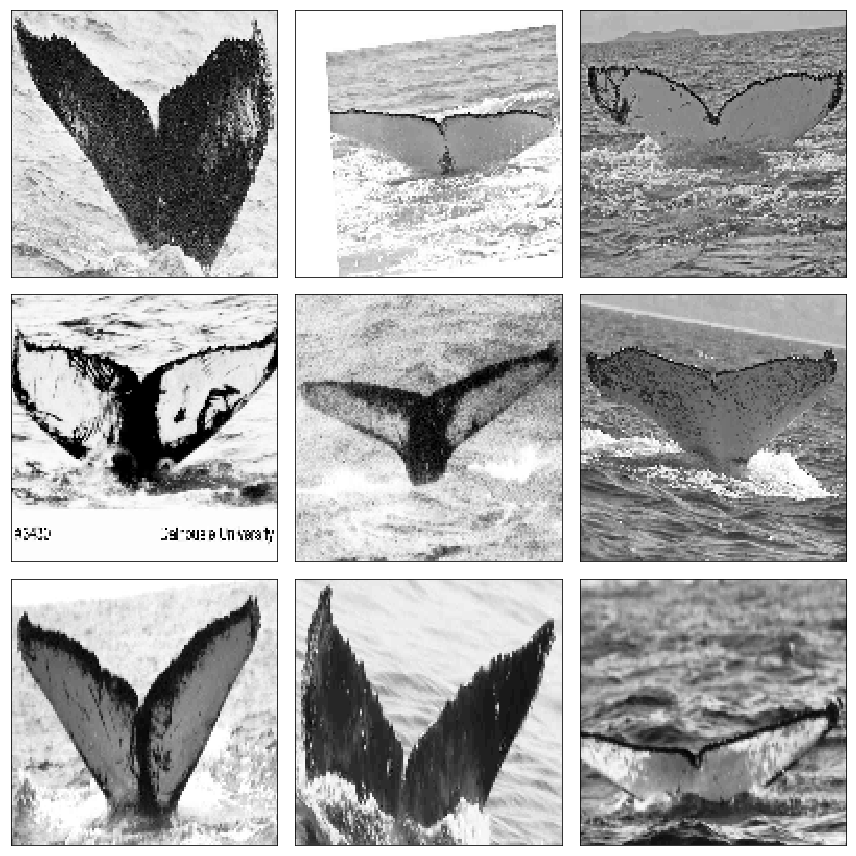

In [8]:
#plotting training images from training set after resizing and BW conversion
plotImages( x)

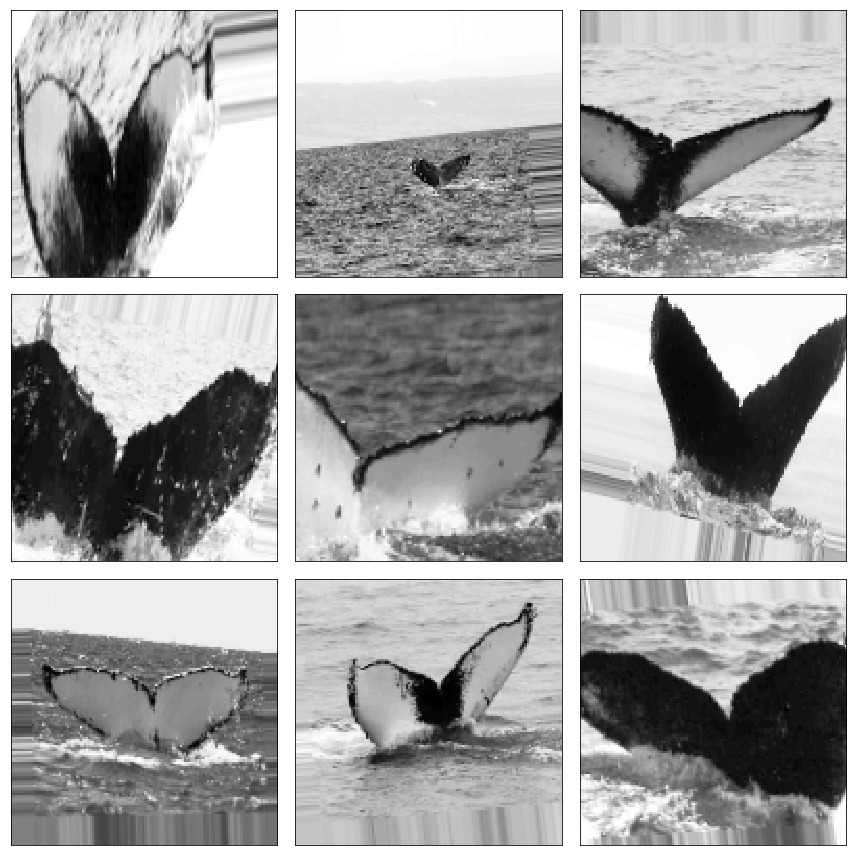

In [9]:
#use of an image generator for preprocessing and data augmentation
x = x.reshape( (-1,SIZE,SIZE,1))
input_shape = x[0].shape
x_train = x.astype("float32")
y_train = y_cat

image_gen = ImageDataGenerator(zoom_range=0.3,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#training the image preprocessing
image_gen.fit(x_train, augment=True)

#visualization of some images out of the preprocessing
augmented_images, _ = next(image_gen.flow( x_train, y_train.toarray(), batch_size=3*3))
plotImages(augmented_images)

In [16]:
batch_size = 32
num_classes = len(y_cat.toarray()[0])
epochs = 30

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding= 'same', strides=(2, 2), activation='relu', 
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(32, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch=  x_train.shape[0]//batch_size,
          epochs=epochs,
          verbose=1,
          class_weight=class_weight_dic)

#score = model.evaluate(x_train, y_train, verbose=0)
#print('Training loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))

x_train shape: (9850, 128, 128, 1)
9850 train samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 64)        102464    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)   

In [17]:
import warnings
from os.path import split

with open(path+"sample_submission.csv","w") as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        for image in test_images:
            img = ImportImage( image)
            x = img.astype( "float32")
            #applying preprocessing to test images
            x = image_gen.standardize( x.reshape(1,SIZE,SIZE))
            
            y = model.predict_proba(x.reshape(1,SIZE,SIZE,1))
            predicted_args = np.argsort(y)[0][::-1][:5]
            predicted_tags = lohe.inverse_labels( predicted_args)
            image = split(image)[-1]
            predicted_tags = " ".join( predicted_tags)
            f.write("%s,%s\n" %(image, predicted_tags))